### 🌸 dummy annotation 데이터

In [24]:
dummy_annotation = "clef-percussion+timeSignature-4/4+note-G5_quarter+rest_quarter+note-G5_quarter+note-C5_eighth.+note-C5_eighth+barline+note-G5_quarter+rest_quarter+note-C5_eighth+barline+note-G5_quarter+rest_quarter+note-G5_quarter+note-C5_eighth.+note-C5_eighth+barline+note-G5_quarter+rest_quarter+note-G5_quarter+note-C5_eighth.+note-C5_eighth+barline+note-G5_quarter+rest_quarter+note-G5_quarter+note-C5_eighth.+note-C5_eighth+barline+note-G5_quarter+rest_quarter+note-G5_quarter+note-C5_eighth.+note-C5_eighth+barline+note-G5_quarter+rest_quarter+note-G5_quarter+note-C5_eighth.+note-C5_eighth+barline+note-G5_quarter+rest_quarter+note-G5_quarter+note-C5_eighth.+note-C5_eighth+barline+note-G5_quarter+rest_quarter+note-G5_quarter+note-C5_eighth.+note-C5_eighth+barline+note-G5_quarter+rest_quarter+note-G5_quarter+note-C5_eighth.+note-C5_eighth+barline+note-G5_quarter+rest_quarter+note-G5_quarter+note-C5_eighth.+note-C5_eighth+barline"

In [38]:
created_annotation = "ote-G5_quarter|note-A4_quarter+note-G5_quarter+rest_quarter+rest_quarter+barline"

### 🌸 상수

In [23]:
# 상수들
BARLINE = "barline"
NOTE = "note"
REST = "rest"
NOTEHEAD_X_LIST = ('G5', 'A5', 'D4')
STEM_DIRECTION_UP = "up"
DIVISION_CHORD = '+'
DIVISION_NOTE = '|'
DIVISION_DURATION = '_'
DIVISION_PITCH = '-'

# -- annotation dict key 값들
IS_NOTE = 'is_note'
NOTEHEAD = 'notehead'
NOTEHEAD_X = 'x'
PITCH = "pitch"
DURATION = "duration"

# -- duration type <-> quarterLength match dict
DURATION_TYPE_TO_LENGTH_TEMP = {
    "whole": 4.0,
    "half": 2.0,
    "quarter": 1.0,
    "eighth": 0.5,
    "16th": 0.25,
    "32nd": 0.125,
    "64th": 0.0625,
    "128th": 0.03125,
    "256th": 0.015625,
    "512th": 0.0078125,
    "1024th": 0.00390625,
    "breve": 8.0,
    "longa": 16.0,
    "maxima": 32.0,
}
DURATION_TYPE_TO_LENGTH = {}
for duration_type, quarter_length in DURATION_TYPE_TO_LENGTH_TEMP.items():
    DURATION_TYPE_TO_LENGTH[duration_type] = quarter_length
    DURATION_TYPE_TO_LENGTH[duration_type + '.'] = quarter_length + quarter_length / 2

### 🌸 annotation 쪼개기

In [4]:
"""
result dict

[
    # 마디
    [
        # 마디 안의 동시에 친 음표
        [
            {
                "is_note": True, 
                "notehead": 'x', 
                "pitch": 'G5',
                "duration": 1.0,
            },
            {
                "is_note": True, 
                "notehead": None, 
                "pitch": 'G5',
                "duration": 0.75,
            },
            ...
        ],
        ...
    ],
    ...
]
"""
def split_annotation(annotation):
    annotation_dict_list = []

    # 마디 기준 ('barline') 으로 자르기
    bar_list = annotation.split(BARLINE)

    for bar_info in bar_list:
        if bar_info == '':
            continue

        # 동시에 친 음표 기준 ('+') 으로  자르기
        chord_list = bar_info.split(DIVISION_CHORD)
        annotation_chord_list = []
        for chord_info in chord_list:
            if chord_info == '' or (chord_info[0:4] != NOTE and chord_info[0:4] != REST):
                continue

            # 노트 얻기 ('|' 기준으로 자르기)
            note_list = chord_info.split(DIVISION_NOTE)
            annotation_note_list = []
            for note_info in note_list:
                if note_info == '':
                    continue
                
                # 노트 정보 객체
                note_info_dict = {}
                
                # note, rest, pitch, duration 얻기
                pitch_info, duration = note_info.split(DIVISION_DURATION)
                pitch_info_list = pitch_info.split(DIVISION_PITCH)
                note_info_dict[DURATION] = DURATION_TYPE_TO_LENGTH[duration]
                note_info_dict[IS_NOTE] = (pitch_info_list[0] == NOTE)
                if pitch_info_list[0] == NOTE: # 음표
                    note_info_dict[IS_NOTE] = True
                    note_info_dict[PITCH] = pitch_info_list[1]
                    note_info_dict[NOTEHEAD] = None
                    if pitch_info_list[1] in NOTEHEAD_X_LIST:
                        note_info_dict[NOTEHEAD] = NOTEHEAD_X

                annotation_note_list.append(note_info_dict)
            annotation_chord_list.append(annotation_note_list)
        annotation_dict_list.append(annotation_chord_list)

    return annotation_dict_list



In [9]:
split_annotation(dummy_annotation)

[[[{'duration': 1.0, 'is_note': True, 'pitch': 'G5', 'notehead': 'x'}],
  [{'duration': 1.0, 'is_note': False}],
  [{'duration': 1.0, 'is_note': True, 'pitch': 'G5', 'notehead': 'x'}],
  [{'duration': 0.75, 'is_note': True, 'pitch': 'C5', 'notehead': None}],
  [{'duration': 0.5, 'is_note': True, 'pitch': 'C5', 'notehead': None}]]]

### 🌸 score 객체 -> xml tree

In [36]:
import xml.etree.ElementTree as ET
from music21.musicxml import m21ToXml

def m21_score_to_xml_tree(m21_score):
    # MusicXML string으로 변환
    musicxml_string = m21ToXml.GeneralObjectExporter(m21_score).parse()

    # XML Tree 구조로 변환
    xml_tree = ET.ElementTree(ET.fromstring(musicxml_string))

    # XML 파일로 저장
    # xml_tree.write('example_score.xml', encoding='utf-8', xml_declaration=True)

    return xml_tree

### 🌸 박자에 맞게 마디 안 음표 조정

In [18]:
"""
result dict : 4/4 박자에 맞는 마디별 음표 정보

annotation: 
[[[{'duration': 1.0, 'is_note': True, 'pitch': 'G5', 'notehead': 'x'}],
  [{'duration': 1.0, 'is_note': False}],
  [{'duration': 1.0, 'is_note': True, 'pitch': 'G5', 'notehead': 'x'}],
  [{'duration': 0.5, 'is_note': True, 'pitch': 'C5', 'notehead': None}],
  [{'duration': 1.0, 'is_note': True, 'pitch': 'C5', 'notehead': None}]]]

result: 
[[[{'duration': 1.0, 'is_note': True, 'pitch': 'G5', 'notehead': 'x'}],
  [{'duration': 1.0, 'is_note': False}],
  [{'duration': 1.0, 'is_note': True, 'pitch': 'G5', 'notehead': 'x'}],
  [{'duration': 0.5, 'is_note': True, 'pitch': 'C5', 'notehead': None}],
  [{'duration': 0.5, 'is_note': False}]]]
"""
def fit_annotation_bar(annotation_dict):
    result_annotation = []
    total_duration_4_4 = 4.0

    for bar in annotation_dict:
        sum_duration = 0
        chord_annotation = []
        for chord_info in bar:
            first_duration = chord_info[0][DURATION]
            if sum_duration + first_duration > total_duration_4_4:
                break
            chord_annotation.append(chord_info)
            sum_duration += first_duration
        rest_duration = total_duration_4_4 - sum_duration
        if rest_duration > 0:
            chord_annotation.append([{DURATION: rest_duration, IS_NOTE: False}])
        result_annotation.append(chord_annotation)
    
    return result_annotation

### 🌸 xml 만들기

In [22]:
from music21 import stream, instrument, clef, meter, note, percussion

"""
xml tree 형태 리턴
"""
def annotation_to_musicxml(annotation):
    annotation_dict = split_annotation(annotation)
    annotation_dict = fit_annotation_bar(annotation_dict)

    # Score 객체 생성
    score = stream.Score()

    # Drum Track 생성
    drum_track = stream.Part()
    drum_track.append(instrument.Percussion())

    # Drum Clef 생성
    drum_clef = clef.PercussionClef()
    drum_track.append(drum_clef)

    # 4/4 Time Signature 생성
    time_signature = meter.TimeSignature('4/4')
    drum_track.append(time_signature)

    for bar in annotation_dict:
        for chord_info in bar:
            chord_notes = []
            is_note = any(item[IS_NOTE] for item in chord_info) # 하나라도 음표 있다면 

            if not is_note: # 쉼표
                r = note.Rest()
                r.duration.quarterLength = chord_info[0][DURATION]
                drum_track.append(r)
                continue
            
            # 음표
            for note_info in chord_info:
                if note_info[IS_NOTE]: # 음표
                    # unpitched 음표 생성
                    n = note.Unpitched(displayName=note_info[PITCH])
                    n.duration.quarterLength = note_info[DURATION]            
                    n.stemDirection = STEM_DIRECTION_UP

                    if note_info[NOTEHEAD] != None:
                        n.notehead = note_info[NOTEHEAD]
                    chord_notes.append(n)

            chord = percussion.PercussionChord(chord_notes)
            chord.stemDirection = STEM_DIRECTION_UP  # Chord의 모든 노트의 꼬리 방향을 위로 설정
            drum_track.append(chord)    

    # Score에 Drum Track 추가
    score.insert(0, drum_track)
    score.show()

    xml_tree = m21_score_to_xml_tree(score)

    return xml_tree


### 🌸 Run !

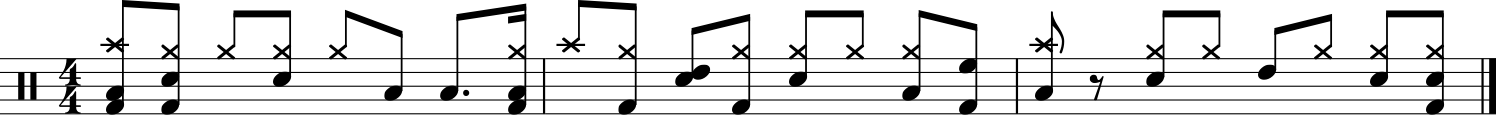

In [52]:
created_annotation = "clef-percussion+timeSignature-4/4+clef-percussion+timeSignature-4/4+note-A5_eighth|note-F4_eighth|note-A4_eighth+note-G5_eighth|note-C5_eighth|note-F4_eighth+note-G5_eighth+note-G5_eighth|note-C5_eighth+note-G5_eighth+note-A4_eighth+note-A4_eighth.+note-G5_16th|note-A4_16th|note-F4_16th+barline+note-A5_eighth+note-G5_eighth|note-F4_eighth+note-D5_eighth|note-C5_eighth+note-G5_eighth|note-F4_eighth+note-G5_eighth|note-C5_eighth+note-G5_eighth+note-G5_eighth|note-A4_eighth+note-E5_eighth|note-F4_eighth+barline+note-A5_eighth|note-A4_eighth+rest_eighth+note-G5_eighth|note-C5_eighth+note-G5_eighth+note-D5_eighth+note-G5_eighth+note-G5_eighth|note-C5_eighth+note-G5_eighth|note-F4_eighth|note-C5_eighth+barline"
xml_tree = annotation_to_musicxml(created_annotation)

### 🗑️ Test Code

['note-F4_quarter', 'note-A5_quarter']
['rest_quarter']
['rest_half']


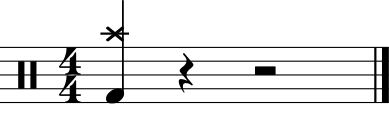

PosixPath('/mnt/c/Users/BaeSuA/Documents/GitHub/optical-music-recognition/notebooks/drum_score_test.xml')

In [13]:
import music21 as m21
from music21 import stream, instrument, clef, meter, note, bar

# 주어진 annotation 문자열
annotation = "note-F4_quarter|note-A5_quarter+rest_quarter+rest_half+barline"

# Score 객체 생성
score = stream.Score()

# Drum Track 생성
drum_track = stream.Part()
drum_track.append(instrument.Percussion())

# Drum Clef 생성
drum_clef = clef.PercussionClef()
drum_track.append(drum_clef)

# 4/4 Time Signature 생성
time_signature = meter.TimeSignature('4/4')
drum_track.append(time_signature)

# barline을 기준으로 annotation을 분할
barlines = annotation.split('+')

# 각 barline에 대해 처리
for barline in barlines:
    if barline == "barline":
        continue
    # barline 내의 각 노트 및 리듬을 분할
    elements = barline.split('|')
    chord_notes = []
    is_rest = False
    print(elements)
    for element in elements:
        # note 또는 rest 확인
        pitch, duration = element.split('_')
        pitch_info = pitch.split("-")

        if pitch_info[0] == 'note':
            # 동시에 친 음의 연결 확인
            n = m21.note.Unpitched(displayName=pitch_info[1])
            n.duration.type = duration            
            n.stemDirection = 'up'

            if pitch_info[1] == 'G5' or pitch_info[1] == 'A5' or pitch_info[1] == 'D4':
                n.notehead = 'x'
            chord_notes.append(n)

        elif pitch_info[0] == 'rest':
            is_rest = True
            r = note.Rest()
            r.duration.type = duration
            drum_track.append(r)

    if not is_rest:
        chord =  m21.percussion.PercussionChord(chord_notes)
        chord.stemDirection = 'up'  # Chord의 모든 노트의 꼬리 방향을 위로 설정
        drum_track.append(chord)

drum_track.append(bar.Barline())

# Score에 Drum Track 추가
score.insert(0, drum_track)
score.show()

# MusicXML 파일로 저장
score.write('musicxml', "drum_score_test.xml")


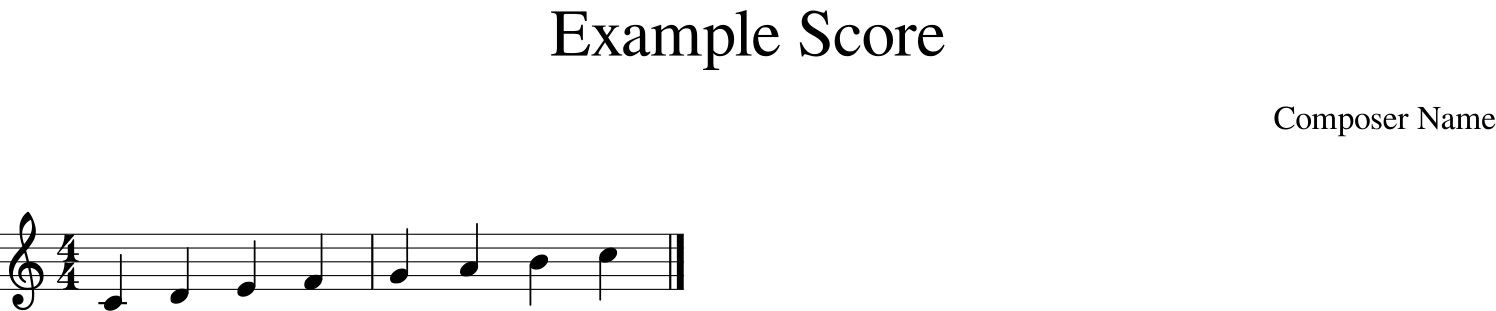

악보가 생성되었습니다.


In [33]:
from music21 import stream, note, metadata

# Score 객체 생성
score = stream.Score()

# 메타데이터 추가 (선택사항)
score.metadata = metadata.Metadata()
score.metadata.title = 'Example Score'
score.metadata.composer = 'Composer Name'

# 파트 생성
part = stream.Part()

# 음표들을 추가하면서 줄바꿈을 수행
part.append(note.Note('C4', quarterLength=1))
part.append(note.Note('D4', quarterLength=1))
part.append(note.Note('E4', quarterLength=1))

# # 첫 번째 마디 종료 후 줄바꿈 추가
# part.append(stream.Measure())  # 마디 구분을 위해 Measure 객체를 추가하여 줄바꿈을 표현

part.append(note.Note('F4', quarterLength=1))
part.append(note.Note('G4', quarterLength=1))
part.append(note.Note('A4', quarterLength=1))
part.append(note.Note('B4', quarterLength=1))
part.append(note.Note('C5', quarterLength=1))

# 파트를 Score 객체에 추가
score.append(part)

# Score 객체를 MusicXML 파일로 저장
score.write('musicxml', fp='example_score.xml')
score.show()

print('악보가 생성되었습니다.')
